In [1]:
import pandas as pd

Refer to [link](https://files.grouplens.org/datasets/movielens/ml-25m-README.html) for more information about this open source dataset.

In [2]:
g_scores_df = pd.read_csv('../data/genome-scores.csv')
g_tags_df = pd.read_csv('../data/genome-tags.csv')
links_df = pd.read_csv('../data/links.csv')
ratings_df = pd.read_csv('../data/ratings.csv')
tags_df = pd.read_csv('../data/tags.csv')
movies_df = pd.read_csv('../data/movies.csv')

# What are we doing?
First thing that we need to do is to prepare the data. So what do we need?
We have a lot of information here so let's go dataset by dataset

- __Genome-scores__: We get relevance for tags from this and this will allow us to reduce the number of tags associated with each movie. So what does high / low relevance mean? Where should we place our threshold?
- __g_tags_df__: This is a bridging table and will allow us to (1) provie a more human readable output for out system and (2) can be used with NLP techniques (Content-based)
- __links_df__: Another bridging table that will allow us to easily(?) merge our enrichment set. (Content-based?)
- __ratings_df__: The crux and meat of our data. (1) What ratings are we seeing? How do the distributions look? (sample) (2) How does the time of events for watching movies look? Should we include movies from users which were watched 1 year apart? How taste changed so much by that point? Can we test this?
- __tags_df__: Allows us to include more information about a movie. (Content-based)
- __movies_df__: (1) Add genres (Content-based)

Additionally - We should probably include a general genre trend e.g. Seasonal (Romance towards Christmas), Blockbusters (Action, Comedy)


## Tag Relevance Scores

In [3]:
g_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


### What is the distribution?
How have relevance scores been scored? Manual or is this frequency based?

<AxesSubplot:ylabel='Frequency'>

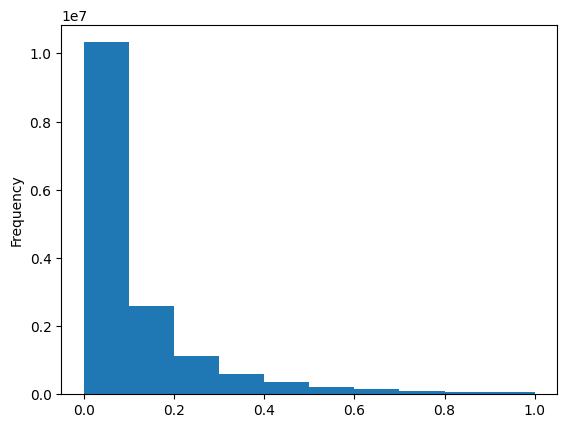

In [4]:
g_scores_df['relevance'].plot(kind='hist')

In [5]:
## We've found that > 6000 tags have a relevance of greater than 0.99, so let's take a look at what they are
g_scores_df[g_scores_df['relevance'] > 0.99].describe()

,movieId,tagId,relevance
count,6591.000000,6591.000000,6591.000000
mean,38405.554696,611.644970,0.994968
std,47084.649253,333.235151,0.002845
min,1.000000,1.000000,0.990250
25%,3435.000000,334.500000,0.992500
50%,7454.000000,631.000000,0.995000
75%,66253.500000,927.000000,0.997250
max,180737.000000,1128.000000,1.000000


In [6]:
g_scores_df[g_scores_df['relevance'] < 0.01].describe()

,movieId,tagId,relevance
count,1.168522e+06,1.168522e+06,1.168522e+06
mean,4.628220e+04,5.507431e+02,6.445020e-03
std,5.308064e+04,3.357408e+02,2.228687e-03
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,4.237000e+03,2.250000e+02,4.750000e-03
50%,2.575700e+04,5.710000e+02,6.750000e-03
75%,8.164100e+04,8.260000e+02,8.250000e-03
max,2.064990e+05,1.128000e+03,9.750000e-03


In [7]:
g_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
subset_g_scores_df_best = g_scores_df[g_scores_df['relevance'] > 0.99][:20]
subset_g_scores_df_best['tag'] = subset_g_scores_df_best['tagId'].apply(lambda x: g_tags_df[g_tags_df['tagId'] == x]['tag'].values[0])
subset_g_scores_df_best['tag']

243      computer animation
785         pixar animation
1035                   toys
10152                   007
10153          007 (series)
10302                  bond
12090             president
13365                 spoof
13599             animation
16575               pirates
16792          swashbuckler
16835         treasure hunt
17106                casino
17342              gangster
17343             gangsters
17541                 mafia
17577                   mob
17660       organized crime
24590         serial killer
24896              assassin
Name: tag, dtype: object

In [9]:
subset_g_scores_df_worst = g_scores_df[g_scores_df['relevance'] < 0.01][:20]
subset_g_scores_df_worst['tag'] = subset_g_scores_df_worst['tagId'].apply(lambda x: g_tags_df[g_tags_df['tagId'] == x]['tag'].values[0])
subset_g_scores_df_worst['tag']

13                  9/11
73                arnold
87            australian
88     author:alan moore
102           bad sequel
103               ballet
105             baseball
116               batman
118              beatles
186               casino
208         christianity
224        coen brothers
294        depp & burton
346          emma watson
391       figure skating
475            gross-out
479             gulf war
487             handycam
488      hannibal lecter
540                india
Name: tag, dtype: object

In [10]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [11]:
## Now that we've found some of the best and worst for relevance, let's find their frequency in the data
def tag_counts(tag_list, tag):
    tag_count = tag_list.count(tag)
    return tag_count

In [12]:
subset_g_scores_df_worst['tag_count'] = subset_g_scores_df_worst['tag'].apply(lambda x: tag_counts(tags_df['tag'].to_list(), x))
subset_g_scores_df_best['tag_count'] = subset_g_scores_df_best['tag'].apply(lambda x: tag_counts(tags_df['tag'].to_list(), x))

In [13]:
print(subset_g_scores_df_worst)

     movieId  tagId  relevance                tag  tag_count
13         1     14    0.00700               9/11         66
73         1     74    0.00975             arnold        236
87         1     88    0.00575         australian         75
88         1     89    0.00675  author:alan moore          0
102        1    103    0.00725         bad sequel         80
103        1    104    0.00400             ballet        208
105        1    106    0.00525           baseball        291
116        1    117    0.00550             batman        101
118        1    119    0.00375            beatles         10
186        1    187    0.00900             casino        190
208        1    209    0.00825       christianity        268
224        1    225    0.00675      coen brothers        142
294        1    295    0.00750      depp & burton          1
346        1    347    0.00800        emma watson         17
391        1    392    0.00600     figure skating         56
475        1    476    0

In [14]:
print(subset_g_scores_df_best)

       movieId  tagId  relevance                 tag  tag_count
243          1    244    0.99875  computer animation        313
785          1    786    0.99575     pixar animation         17
1035         1   1036    0.99925                toys         80
10152       10      1    0.99950                 007        214
10153       10      2    1.00000        007 (series)         75
10302       10    151    0.99900                bond         44
12090       11    811    0.99675           president         95
13365       12    958    0.99275               spoof        398
13599       13     64    0.99200           animation       2661
16575       15    784    0.99025             pirates        444
16792       15   1001    0.99175        swashbuckler        129
16835       15   1044    0.99775       treasure hunt        308
17106       16    187    0.99325              casino        190
17342       16    423    0.99150            gangster        558
17343       16    424    0.99025        

Since the description of our data tells us *'The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.'* we can assume from our findings that the relevance score does not correspond to the frequency. We might be able to assume that the relevance score is based on the output of the machine learning algorithm used to generate it. So how many tags on average are associated to each movie?

In [15]:
g_scores_df.groupby('movieId')['movieId'].count().sort_index()

movieId
1         1128
2         1128
3         1128
4         1128
5         1128
          ... 
205072    1128
205076    1128
205383    1128
205425    1128
206499    1128
Name: movieId, Length: 13816, dtype: int64

In [16]:
# Quick sanity check. We have 13816 unique movie Id's and for each movie, there appears to the 1128 tags. Does this match the dataframe shape?
print(g_scores_df.shape)
print(g_tags_df.shape)
13816*1128

(15584448, 3)
(1128, 2)


15584448

Great, now since we know that each movie has the same tags applied, we need to whittle them down to the most relevant for each. So let's take a look at what we've got and where we should set a sensible threshold. 

In [17]:
g_scores_df['points_bin'] = pd.cut(g_scores_df['relevance'], bins=[0, .2, .4, .6, .8, 1])
agg_g_scores_df = g_scores_df.groupby('movieId')['points_bin'].value_counts().to_frame()

<AxesSubplot:ylabel='Frequency'>

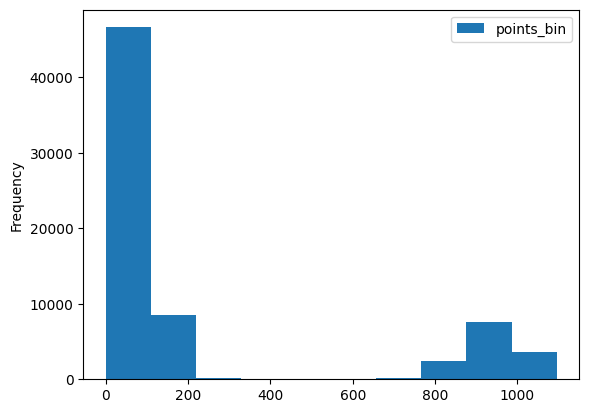

In [24]:
agg_g_scores_df.plot(kind='hist')

<AxesSubplot:>

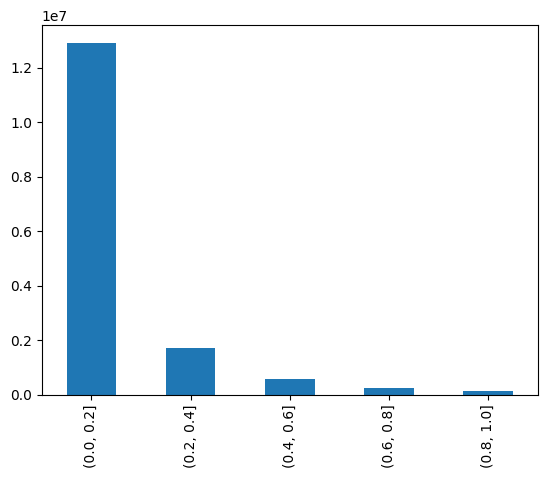

In [21]:
g_scores_df['points_bin'].value_counts().plot(kind='bar')